# Fast Segment Anything Model (FastSAM)

---

The Fast Segment Anything Model (FastSAM) is a CNN Segment Anything Model trained by only 2% of the SA-1B dataset published by SAM authors.
The FastSAM authors claim it achieves comparable performance to the SAM method at 50 times the speed.

<!-- ![fast-segment-anything-model-figure-1](https://media.roboflow.com/notebooks/examples/fast-sam-figure-1.png) -->



<!-- ![fast-segment-anything-model-figure-2](https://media.roboflow.com/notebooks/examples/fast-sam-figure-2.png) -->


## Steps 

- Before you start
- Install FastSAM, SAM, and other dependencies
- Download FastSAM and SAM weights
- Download example data
- Imports
- Load FastSAM
- FastSAM inference
- FastSAM box prompt inference
- FastSAM point prompt inference
- FastSAM text prompt inference
- SAM vs FastSAM
- Roboflow benchmark dataset

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sat Jul 15 08:32:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /kaggle/working


## Install FastSAM, SAM, and other dependencies

In [3]:
%cd {HOME}

# install FastSAM
!git clone https://github.com/CASIA-IVA-Lab/FastSAM.git
!pip -q install -r FastSAM/requirements.txt
# install CLIP
!pip -q install git+https://github.com/openai/CLIP.git
# install SAM
!pip -q install git+https://github.com/facebookresearch/segment-anything.git
# install other dependencies
!pip -q install roboflow supervision jupyter_bbox_widget

/kaggle/working
Cloning into 'FastSAM'...
remote: Enumerating objects: 654, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 654 (delta 100), reused 121 (delta 85), pack-reused 493
Receiving objects: 100% (654/654), 65.99 MiB | 35.17 MiB/s, done.
Resolving deltas: 100% (369/369), done.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-lsp 4.2.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pytoolconfig 1.2.5 requires packaging>=22.0, but you have packaging 21.3 which is incompatible.
ydata-profiling 4.3.1 requires scipy<1.11,>=1.4.1, but you have scipy 1.11.1 which is incompatible.


## Download FastSAM and SAM weights

In [4]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt
!wget -P {HOME}/weights -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!ls -lh {HOME}/weights

total 2.6G
-rw-r--r-- 1 root root 139M Jun 20 07:01 FastSAM.pt
-rw-r--r-- 1 root root 2.4G Apr  4 06:56 sam_vit_h_4b8939.pth


In [5]:
FAST_SAM_CHECKPOINT_PATH = f"{HOME}/weights/FastSAM.pt"
SAM_SAM_CHECKPOINT_PATH = f"{HOME}/weights/sam_vit_h_4b8939.pth"

## Download example data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [7]:
import os
import cv2
import torch
import roboflow
import base64
import nibabel as nib
import glob
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import supervision as sv
import numpy as np

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5


In [10]:
!mkdir -p {HOME}/data
!wget -P {HOME}/data -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -P {HOME}/data -q https://media.roboflow.com/notebooks/examples/robot.jpeg

!ls -lh {HOME}/data

total 532K
-rw-r--r-- 1 root root 104K Jun  2 16:01 dog.jpeg
-rw-r--r-- 1 root root 426K Jul  5 17:33 robot.jpeg


## Imports

**NOTE:** `FastSAM` code is not distributed via `pip` not it is packaged. Make sure to run code balow from `{HOME}/FastSAM` directory. ⚠️

In [11]:
%cd {HOME}/FastSAM

import os
import cv2
import torch
import roboflow
import base64

import supervision as sv
import numpy as np

from roboflow import Roboflow
from fastsam import FastSAM, FastSAMPrompt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

/kaggle/working/FastSAM


## Load FastSAM

In [12]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fast_sam = FastSAM(FAST_SAM_CHECKPOINT_PATH)

## FastSAM inference

* `retina_masks=True` determines whether the model uses retina masks for generating segmentation masks.
* `imgsz=1024` sets the input image size to 1024x1024 pixels for processing by the model.
* `conf=0.4` sets the minimum confidence threshold for object detection.
* `iou=0.9` sets the minimum intersection over union threshold for non-maximum suppression to filter out duplicate detections.

In [13]:
# IMAGE_PATH = f"{HOME}/data/dog.jpeg"

In [14]:
IMAGE_PATH = f"{HOME}/data/infection.png"

In [49]:
IMAGE_PATH = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-10003.png"

In [50]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.4,
    iou=0.9)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.everything_prompt()
# prompt_process.plot(annotations=masks, output=f"{HOME}/output")


image 1/1 /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-10003.png: 1024x1024 6 objects, 91.4ms
Speed: 4.9ms preprocess, 91.4ms inference, 2.9ms postprocess per image at shape (1, 3, 1024, 1024)


**NOTE:** `prompt_process.everything_prompt` returns `torch.Tensor`

In [51]:
def annotate_image(image_path: str, masks: np.ndarray) -> np.ndarray:
    image = cv2.imread(image_path)

    xyxy = sv.mask_to_xyxy(masks=masks)
    detections = sv.Detections(xyxy=xyxy, mask=masks)

    mask_annotator = sv.MaskAnnotator()
    return mask_annotator.annotate(scene=image.copy(), detections=detections)

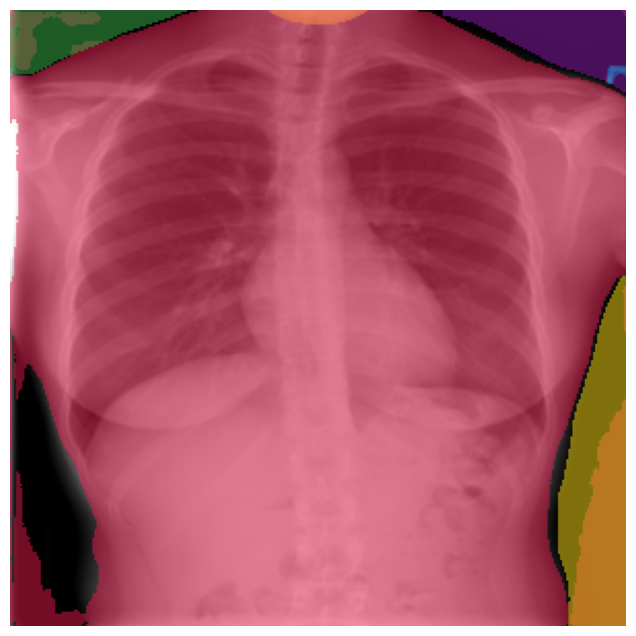

In [52]:
masks = masks.cpu().numpy().astype(bool)
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))

**NOTE:** The quality of the generated masks is quite poor. Let's see if we can improve it by manipulating the parameters.

In [53]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.everything_prompt()


image 1/1 /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-10003.png: 1024x1024 5 objects, 84.9ms
Speed: 5.9ms preprocess, 84.9ms inference, 4.8ms postprocess per image at shape (1, 3, 1024, 1024)


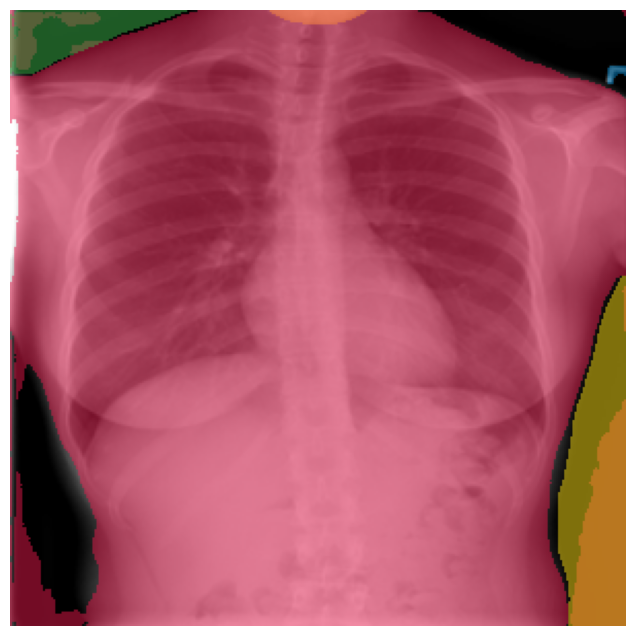

In [54]:
masks = masks.cpu().numpy().astype(bool)
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))

## FastSAM box prompt inference

### Draw Box

In [55]:
# helper function that loads an image before adding it to the widget
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [56]:
IS_COLAB = False

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [57]:
widget.bboxes

[]

### Generate mask with FastSAM

In [58]:
# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = [
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
]

In [59]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.box_prompt(bbox=box)


image 1/1 /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-10003.png: 1024x1024 5 objects, 84.2ms
Speed: 4.6ms preprocess, 84.2ms inference, 3.0ms postprocess per image at shape (1, 3, 1024, 1024)


**NOTE:** `prompt_process.box_prompt` returns `numy.ndarray`

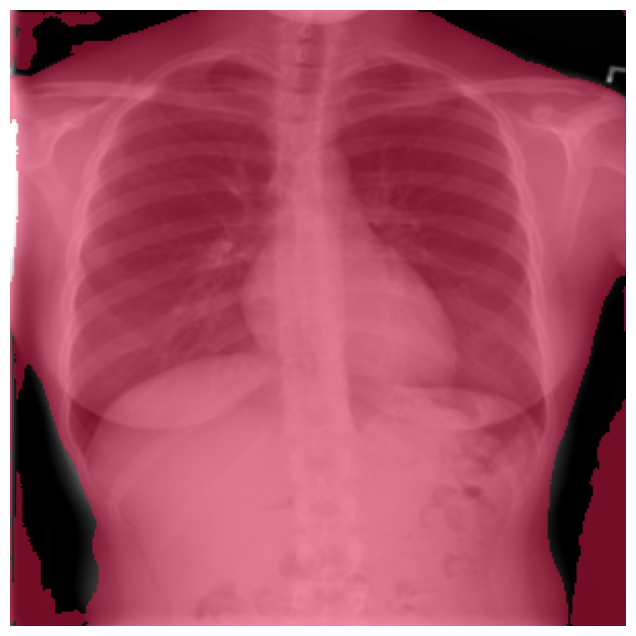

In [60]:
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))

## FastSAM point prompt inference

### Select point

In [61]:
point = [200, 200]

### Generate mask with FastSAM

In [62]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.point_prompt(points=[point], pointlabel=[1])


image 1/1 /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-10003.png: 1024x1024 5 objects, 84.3ms
Speed: 4.7ms preprocess, 84.3ms inference, 2.8ms postprocess per image at shape (1, 3, 1024, 1024)


**NOTE:** `prompt_process.point_prompt` returns `numy.ndarray`

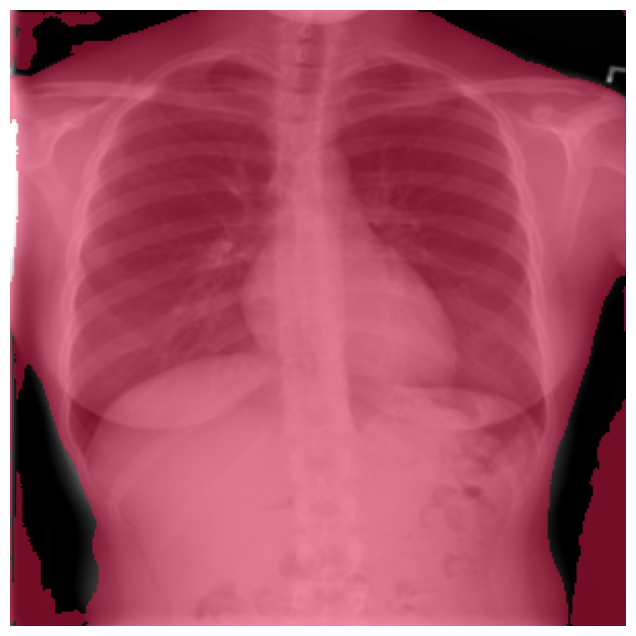

In [63]:
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))

## FastSAM text prompt inference

In [64]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.text_prompt(text='bone')


image 1/1 /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-10003.png: 1024x1024 5 objects, 84.3ms
Speed: 4.8ms preprocess, 84.3ms inference, 2.7ms postprocess per image at shape (1, 3, 1024, 1024)


**NOTE:** `prompt_process.text_prompt` returns `numy.ndarray`

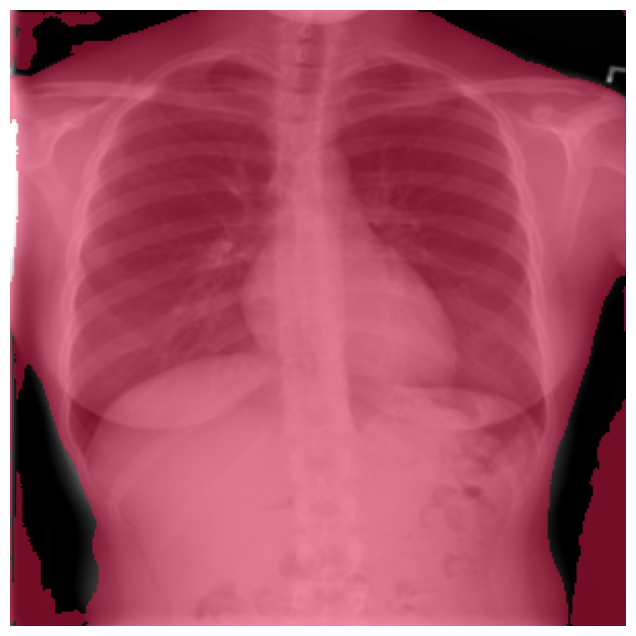

In [65]:
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))

##  SAM vs FastSAM

In [66]:
# IMAGE_PATH = f"{HOME}/data/robot.jpeg"

### Load SAM

In [67]:
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_SAM_CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

### SAM inference

In [68]:
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)
sam_detections = sv.Detections.from_sam(sam_result=sam_result)

### FastSAM inference

In [69]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.everything_prompt()
masks = masks.cpu().numpy().astype(bool)
xyxy = sv.mask_to_xyxy(masks=masks)
fast_sam_detections = sv.Detections(xyxy=xyxy, mask=masks)


image 1/1 /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-10003.png: 1024x1024 5 objects, 84.3ms
Speed: 4.7ms preprocess, 84.3ms inference, 3.1ms postprocess per image at shape (1, 3, 1024, 1024)


### FastSAM vs. SAM

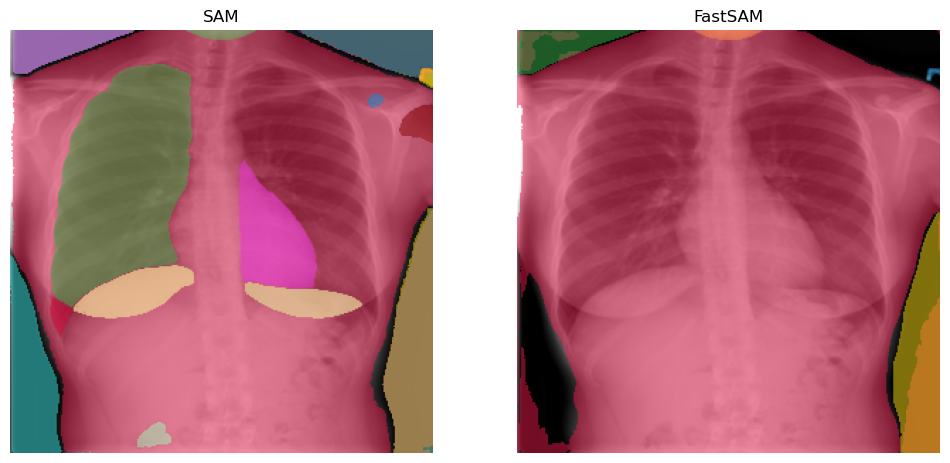

In [70]:
mask_annotator = sv.MaskAnnotator()

sam_result = mask_annotator.annotate(scene=image_bgr.copy(), detections=sam_detections)
fast_sam_result = mask_annotator.annotate(scene=image_bgr.copy(), detections=fast_sam_detections)

sv.plot_images_grid(
    images=[sam_result, fast_sam_result],
    grid_size=(1, 2),
    titles=['SAM', 'FastSAM']
)

**NOTE:** There is a lot going on in our test image. Let's plot our masks against a blank background.

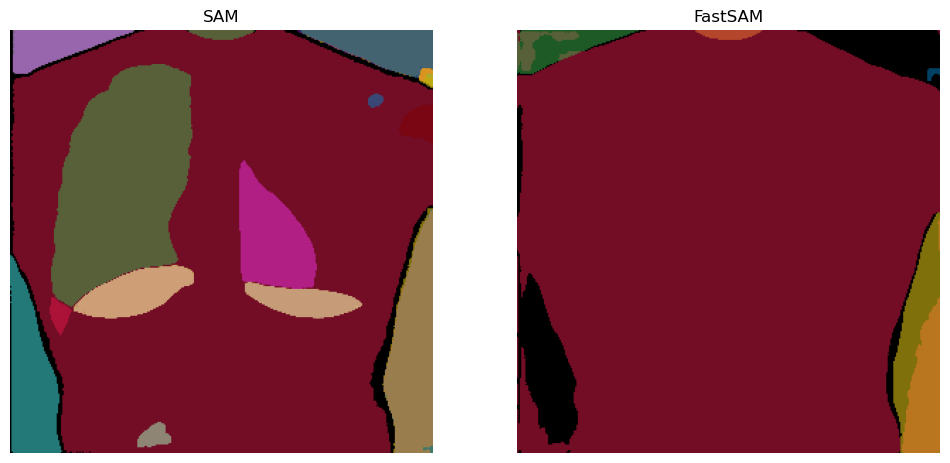

In [71]:
mask_annotator = sv.MaskAnnotator()

sam_result = mask_annotator.annotate(scene=np.zeros_like(image_bgr), detections=sam_detections)
fast_sam_result = mask_annotator.annotate(scene=np.zeros_like(image_bgr), detections=fast_sam_detections)

sv.plot_images_grid(
    images=[sam_result, fast_sam_result],
    grid_size=(1, 2),
    titles=['SAM', 'FastSAM']
)

In [72]:
len(sam_detections.mask), len(fast_sam_detections.mask)

(21, 5)

### Mask diff

**NOTE:** Let's try to understand which masks generated by SAM were not generated by FastSAM.

In [73]:
def DICE_COE(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice 

def mean_pixel_accuracy(pixel_correct, pixel_labeled):
    mean_pixel_accuracy = 1.0 * np.sum(pixel_correct) / (np.spacing(1) + np.sum(pixel_labeled))
    mean_pixel_accuracy = round(mean_pixel_accuracy,2)
    return mean_pixel_accuracy

def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    iou = round(iou, 2)
    return iou

def filter_masks(mask_array1, mask_array2, threshold):
    return np.array([mask1 for mask1 in mask_array1 if max(compute_iou(mask1, mask2) for mask2 in mask_array2) < threshold])

In [74]:
print(f"Dice Coefficient of two same masks are {DICE_COE(sam_result, fast_sam_result)}")

Dice Coefficient of two same masks are 1.806


In [75]:
print(f"Mean Pixel Accuracy of two same masks are {mean_pixel_accuracy(sam_result, fast_sam_result)}")

Mean Pixel Accuracy of two same masks are 1.31


In [76]:
print(f"mIOU of two same masks are {compute_iou(sam_result, fast_sam_result)}")

mIOU of two same masks are 0.93


In [134]:
print(f"Mean Pixel Accuracy of two same masks are {mean_pixel_accuracy(gray_img, gray_img1)}")

Mean Pixel Accuracy of two same masks are 1.82


In [78]:
from skimage import io
from skimage import data
from skimage.color import rgb2gray
from skimage import data

### SAM Result

In [79]:
data2 = Image.open(r"/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks/Normal-10003.png")

In [98]:
gdata2 = rgb2gray(data2)

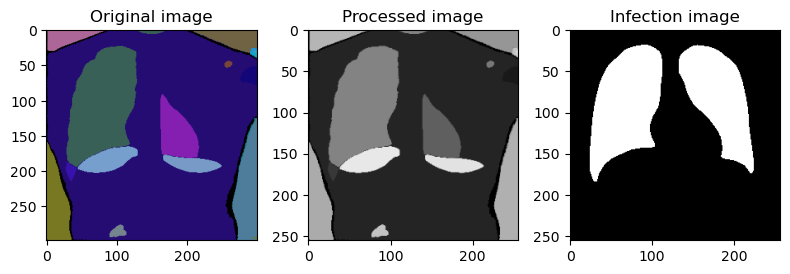

In [137]:
gray_img = rgb2gray(sam_result)
gray_img = cv2.resize(gray_img,(256,256))
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
ax = axes.ravel()
#setting the axes of the image
ax[0].imshow(sam_result)
ax[0].set_title("Original image")
ax[1].imshow(gray_img, cmap=plt.cm.gray)
ax[1].set_title("Processed image")
ax[2].imshow(data2, cmap=plt.cm.gray)
ax[2].set_title("Infection image")
#display the processed image
fig.tight_layout()
plt.show()

In [138]:
print(f"mIOU of two same masks are {compute_iou(gray_img, gdata2)}")

mIOU of two same masks are 0.27


In [139]:
print(f"Dice Coefficient of two same masks are {DICE_COE(gray_img, gdata2)}") #SAM Result

Dice Coefficient of two same masks are 0.258


In [140]:
print(f"Mean Pixel Accuracy of two same masks are {mean_pixel_accuracy(gdata2, gray_img)}")

Mean Pixel Accuracy of two same masks are 1.34


### Fast-SAM Results

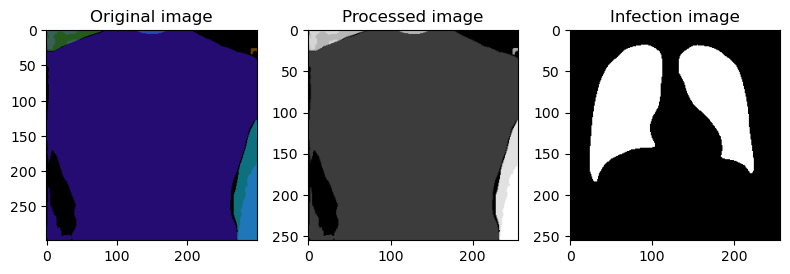

In [141]:
gray_img1  = rgb2gray(fast_sam_result)
gray_img1 = cv2.resize(gray_img1,(256,256))
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
ax = axes.ravel()
#setting the axes of the image
ax[0].imshow(fast_sam_result)
ax[0].set_title("Original image")
ax[1].imshow(gray_img1, cmap=plt.cm.gray)
ax[1].set_title("Processed image")
ax[2].imshow(data2, cmap=plt.cm.gray)
ax[2].set_title("Infection image")
#display the processed image
fig.tight_layout()
plt.show()

In [142]:
print(f"mIOU of two same masks are {compute_iou(gray_img1, gdata2)}")

mIOU of two same masks are 0.28


In [143]:
print(f"Dice Coefficient of two same masks are {DICE_COE(gray_img1, gdata2)}") #Fast SAM Result

Dice Coefficient of two same masks are 0.138


In [144]:
print(f"Mean Pixel Accuracy of two same masks are {mean_pixel_accuracy(gdata2, gray_img1)}")

Mean Pixel Accuracy of two same masks are 2.44


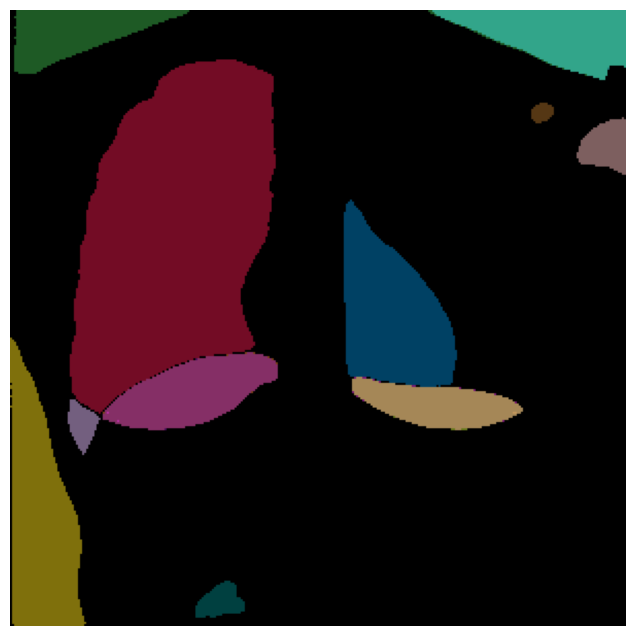

In [145]:
diff_masks = filter_masks(sam_detections.mask, fast_sam_detections.mask, 0.5)
diff_xyxy = sv.mask_to_xyxy(masks=diff_masks)
diff_detections = sv.Detections(xyxy=diff_xyxy, mask=diff_masks)

mask_annotator = sv.MaskAnnotator()
diff_result = mask_annotator.annotate(scene=np.zeros_like(image_bgr), detections=diff_detections)
sv.plot_image(image=diff_result, size=(8, 8))

## Benchmark Dataset

In [ ]:
%cd {HOME}

roboflow.login()
rf = Roboflow()
project = rf.workspace("amala02").project("cancer-detection-xmvfg")
dataset = project.version(4).download("yolov8")
# project = rf.workspace("roboticfish").project("underwater_object_detection")
# dataset = project.version(10).download("yolov8")

In [ ]:
IMAGE_PATH = os.path.join(dataset.location, 'train', 'images', '00285_87_jpg.rf.6f69bed70ee520ff309e00918706eb54.jpg')

In [161]:
IMAGE_PATH = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-101.png"

In [166]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.text_prompt(text='ribs')


image 1/1 /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-101.png: 1024x1024 6 objects, 92.7ms
Speed: 6.1ms preprocess, 92.7ms inference, 4.5ms postprocess per image at shape (1, 3, 1024, 1024)


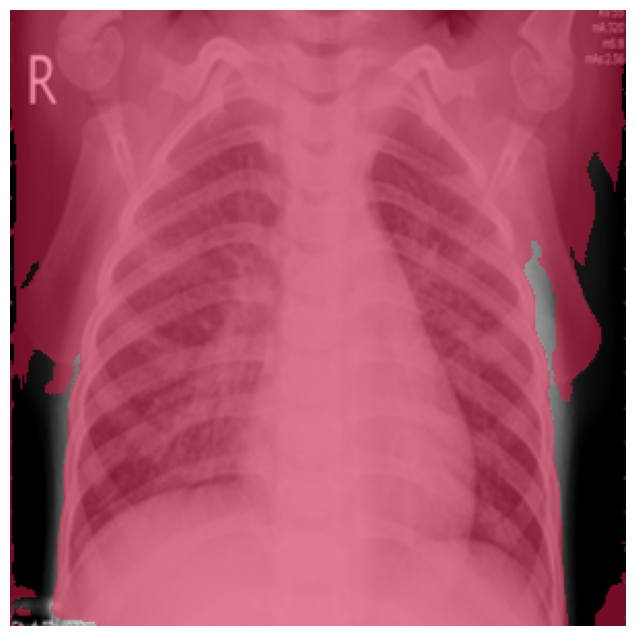

In [167]:
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))